In [8]:
import numpy as np
import torch 
from torchvision import datasets, transforms
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pdb
%matplotlib inline

In [9]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()


# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Files already downloaded and verified


In [11]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [12]:
# get the top1, top2 eigenvectors
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

In [13]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

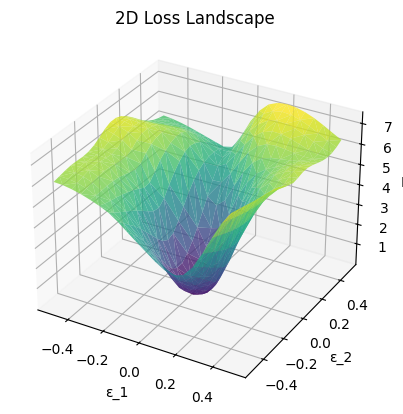

In [14]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams1 = np.linspace(-0.5, 0.5, 21).astype(np.float32)
lams2 = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb1 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb1.eval()
model_perb1 = model_perb1.cuda()

model_perb2 = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb2.eval()
model_perb2 = model_perb2.cuda()


for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_perb1, top_eigenvector[0], lam1)
        model_perb2 = get_params(model_perb1, model_perb2, top_eigenvector[1], lam2)
        loss_list.append((lam1, lam2, criterion(model_perb2(inputs), targets).item()))   

loss_list = np.array(loss_list)
                         
fig = plt.figure()
landscape = fig.add_subplot(111, projection='3d')
landscape.plot_trisurf(loss_list[:,0], loss_list[:,1], loss_list[:,2], alpha=0.8, cmap='viridis')



landscape.set_title('2D Loss Landscape')
landscape.set_xlabel('ε_1')
landscape.set_ylabel('ε_2')
landscape.set_zlabel('Loss')

#landscape.view_init(elev=15, azim=75)
landscape.dist = 6
plt.savefig('2D_loss_landscape.png', dpi=300, bbox_inches='tight')